**Data Preprocessing**

In [1]:
# Set seeds for reproducibility
import random
random.seed(69)

import numpy as np
np.random.seed(69)

import tensorflow as tf
tf.random.set_seed(69)
import tensorflow as tf
print(tf.__version__)


2.10.0


**Setting up GPU**


In [2]:
# Allow memory growth on the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpu_available)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Importing the dependencies**

In [3]:
import os
import json
from zipfile import ZipFile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Dataset Path Setup**

In [4]:
# Dataset Path
base_dir = 'plantvillage_dataset/color'

**Image Data Generators**

In [5]:
# Image Parameters
img_size = 256
batch_size = 96

# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)
# Train and Validation Generators/train test split
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',#train split
    class_mode='categorical'#one hot encoding
)

validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',#test split
    class_mode='categorical'#one hot encoding
)


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


**Data Visualization / EDA**

In [6]:
print(os.listdir("plantvillage_dataset"))
print(len(os.listdir("plantvillage_dataset/color")))
dataset_dir=base_dir
# Count images in each class
class_counts = {}
for class_name in os.listdir(dataset_dir):
    class_folder = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_folder):
        num_images = len([file for file in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, file))])
        class_counts[class_name] = num_images
total=0
for class_name, count in class_counts.items():
    print(f"Class '{class_name}' contains = {count} images.")


['color', 'grayscale', 'segmented', 'test_images']
38
Class 'Apple___Apple_scab' contains = 630 images.
Class 'Apple___Black_rot' contains = 621 images.
Class 'Apple___Cedar_apple_rust' contains = 275 images.
Class 'Apple___healthy' contains = 1645 images.
Class 'Blueberry___healthy' contains = 1502 images.
Class 'Cherry_(including_sour)___healthy' contains = 854 images.
Class 'Cherry_(including_sour)___Powdery_mildew' contains = 1052 images.
Class 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot' contains = 513 images.
Class 'Corn_(maize)___Common_rust_' contains = 1192 images.
Class 'Corn_(maize)___healthy' contains = 1162 images.
Class 'Corn_(maize)___Northern_Leaf_Blight' contains = 985 images.
Class 'Grape___Black_rot' contains = 1180 images.
Class 'Grape___Esca_(Black_Measles)' contains = 1383 images.
Class 'Grape___healthy' contains = 423 images.
Class 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' contains = 1076 images.
Class 'Orange___Haunglongbing_(Citrus_greening)' contain

(256, 256, 3)


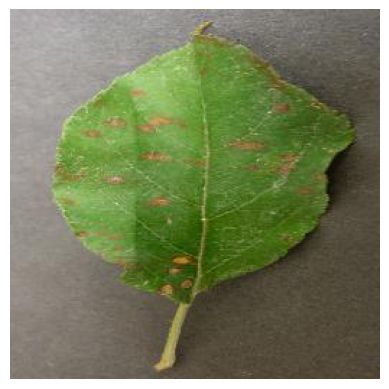

In [7]:
image_path = 'plantvillage_dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'
img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

**Model Creation**

In [8]:
#model defination
model = models.Sequential()

# Convolutional Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.2))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.3))

# Convolutional Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.3))

# Additional Convolutional Block
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.4))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     2

**Model Compilation**

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])

**Compute class weights**

In [10]:
class_labels = list(train_generator.class_indices.keys())# Class names
# print("\n".join(train_generator.class_indices.keys()))
class_samples = train_generator.classes  # Class indices for each image
class_weights = compute_class_weight('balanced', classes=np.unique(class_samples), y=class_samples)
# print(class_weights)
class_weight_dict = dict(zip(np.unique(class_samples), class_weights))

****Model Training and Testing****

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

**Training the Model**

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=np.ceil(train_generator.samples // batch_size).astype(int),  # Number of steps per epoch
    epochs=64,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=np.ceil(validation_generator.samples // batch_size).astype(int),  # Validation steps
    class_weight=class_weight_dict,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/64
452/452 [==============================] - 134s 232ms/step - loss: 13.5769 - accuracy: 0.1911 - precision: 0.6220 - recall: 0.0809 - val_loss: 18.4291 - val_accuracy: 0.0924 - val_precision: 0.1214 - val_recall: 0.0870 - lr: 1.0000e-04
Epoch 2/64
452/452 [==============================] - 95s 210ms/step - loss: 7.7633 - accuracy: 0.4101 - precision: 0.7226 - recall: 0.2729 - val_loss: 8.7772 - val_accuracy: 0.2319 - val_precision: 0.2528 - val_recall: 0.2209 - lr: 1.0000e-04
Epoch 3/64
452/452 [==============================] - 96s 211ms/step - loss: 5.0118 - accuracy: 0.5442 - precision: 0.7702 - recall: 0.4200 - val_loss: 6.9100 - val_accuracy: 0.3212 - val_precision: 0.3414 - val_recall: 0.3037 - lr: 1.0000e-04
Epoch 4/64
452/452 [==============================] - 94s 207ms/step - loss: 3.6419 - accuracy: 0.6357 - precision: 0.7962 - recall: 0.5229 - val_loss: 4.2174 - val_accuracy: 0.5232 - val_precision: 0.5707 - val_recall: 0.4918 - lr: 1.0000e-04
Epoch 5/64
452/452 [=

**Model Evaluation**

In [13]:
print("Evaluating model...")
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(
    validation_generator,
    steps=validation_generator.samples // batch_size
)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Precision: {val_precision * 100:.2f}%")
print(f"Validation Recall: {val_recall * 100:.2f}%")
# Calculate F1 Score
validation_generator.reset()  # Reset the generator
steps = np.ceil(validation_generator.samples / batch_size).astype(int)

# Get predictions
predictions = model.predict(validation_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = validation_generator.classes[:len(predicted_classes)]  # Match lengths

# Calculate F1 Score
f1 = f1_score(true_labels, predicted_classes, average='weighted')  # Use 'macro' or 'micro' as needed
print(f"Validation F1 Score: {f1:.4f}")

Evaluating model...
113/113 [==============================] - 18s 160ms/step - loss: 0.3199 - accuracy: 0.9478 - precision: 0.9527 - recall: 0.9452
Validation Loss: 0.3199
Validation Accuracy: 94.78%
Validation Precision: 95.27%
Validation Recall: 94.52%
114/114 [==============================] - 18s 156ms/step
Validation F1 Score: 0.0467


**Plotting Training Metrics**

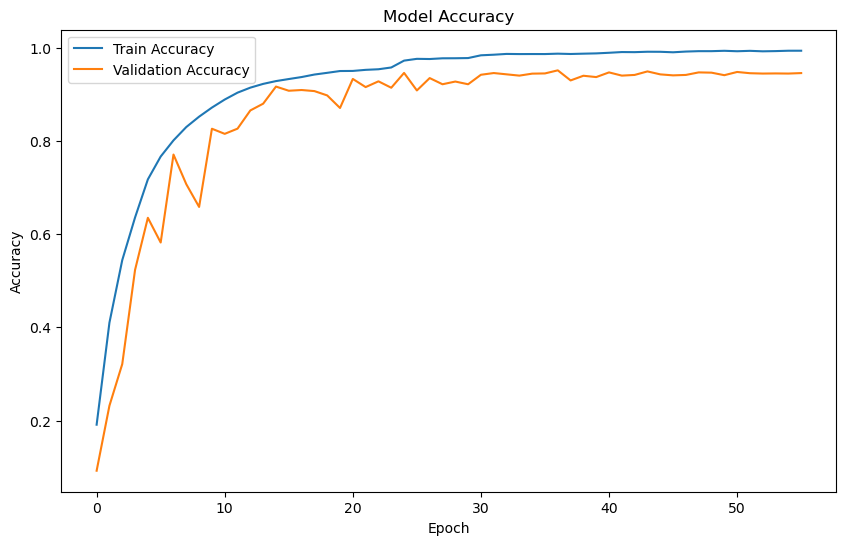

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

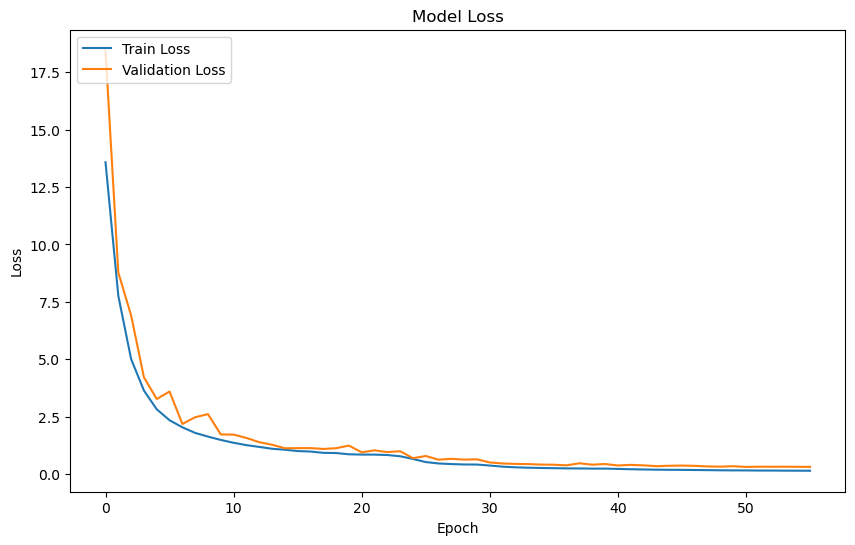

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

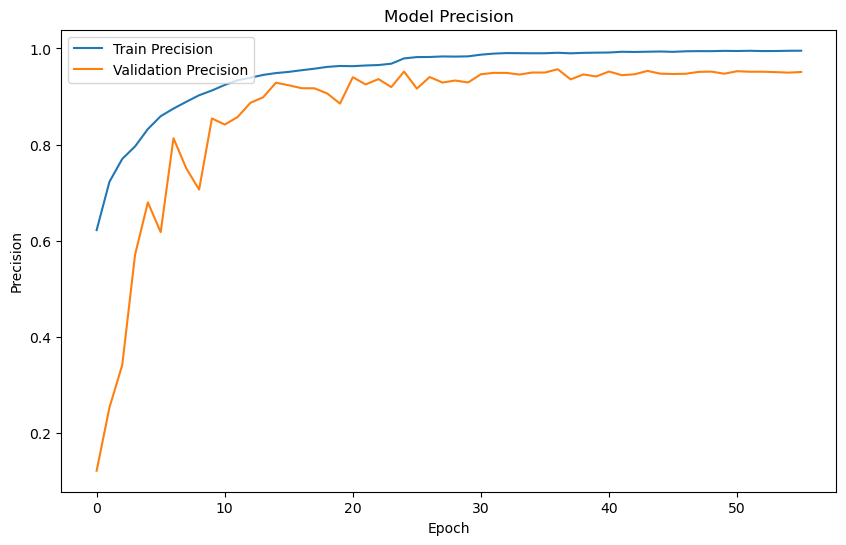

In [16]:
# Plot training & validation precision values
plt.figure(figsize=(10, 6))
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')
plt.show()

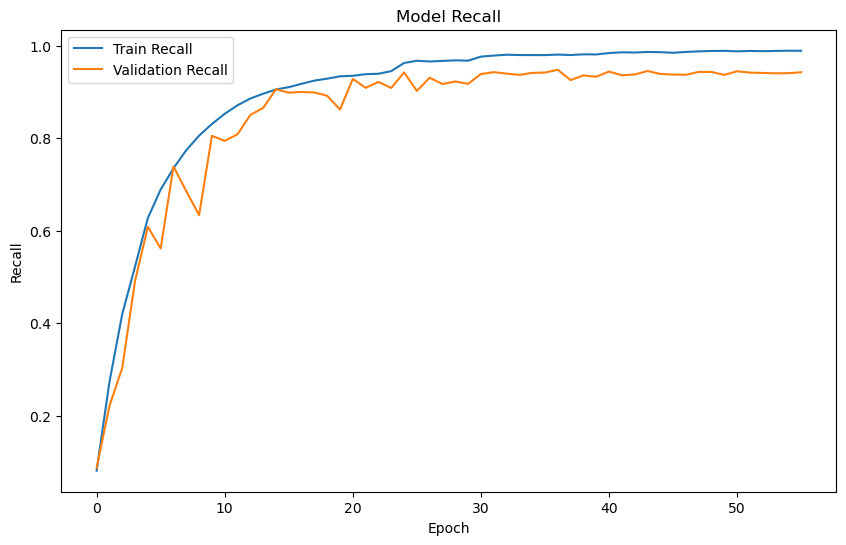

In [17]:
# Plot training & validation recall values
plt.figure(figsize=(10, 6))
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='upper left')
plt.show()

**Model Deployment: Prediction System**

In [18]:
#Image Prediction Function
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    confidence_scores = {class_name: predictions[0][idx] for idx, class_name in class_indices.items()}
    return predicted_class_name, confidence_scores

**Create a mapping from class indices to class names**

In [19]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
json.dump(class_indices, open('class_indices.json', 'w'))
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

**Predicting the Class of a New Image**

In [20]:
#Manual Checking
image_path = 'plantvillage_dataset/test_images/random.JPG'
predicted_class_name, confidence_scores = predict_image_class(model, image_path, class_indices)

print("Predicted Class Name:", predicted_class_name)
# print("Confidence Scores:")
# for class_name, score in confidence_scores.items():
#     print(f"{class_name}: {score}")

1/1 [==============================] - 0s 135ms/step
Predicted Class Name: Tomato___Early_blight


**Save the model**

In [21]:
model.save('plant_disease_prediction_model_1.h5')
model.save('plant_disease_prediction_model_1.keras')